# Introduction
The main idea of this assignment is to calculte the "risk" or "impact score" of bushfire per suburb in Greater Sydney.

There are 6 datasets used in this assignment.

1. Neighbourhoods.csv
2. Businessstats.csv
3. StatisticalAreas.csv
4. RFS
5. SA2
6. RFS Fire Stations

These are all the modules imported for the assignment:

In [1]:
#Import all modules relevant to handling data, including spatial (GeoPandas) and connecting to PgAdmin
import pandas as pd
import math
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
import json
import os

import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import psycopg2
import psycopg2.extras
from geoalchemy2 import Geometry, WKTElement
from sqlalchemy import event, create_engine

# Data Cleaning and Uploading Data to pgAdmin

The first process involves cleaning the datasets and uploading it to pgAdmin. Methods for cleaning data includes:

checkNull(dataset, beenCleaned): check if there's a null value

removeNull(dataset): drop the null value in the dataset

** For each dataset, we also check the type of different columns to see if they are in their correct type. If they're not, then we convert them. For instance, all population values are intially string, but we convert them into numeric values.

In [2]:
# Function use to check if null values exist in the dataset. If there's null value, we'll drop the row to increase 
# accuracy in our calculations.

def checkNull( dataset ):
    
    beenCleaned = False    
    
    for num in list(dataset.isnull().sum()):

        if num != 0:
            print("Null value found. Coverted null values to ...")
            dataset = dataset.dropna() #found null, drop the row
            beenCleaned = True
            
    if beenCleaned:
        print("\nNull values have been removed. You're good to go!")

    else:
        print("\nNo null values in. Good to go, no need for cleaning :)")

    return dataset

This method below is use to connect to the pgAdmin server.

In [3]:
#Connecting to pgAdmin

data_path = "."

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        HOST       = db_conn_dict['host']
        DB_USER    = db_conn_dict['user']
        DB_PW      = db_conn_dict['password']
        DEFAULT_DB = db_conn_dict['user']

        try:
            db = create_engine('postgres+psycopg2://'+DB_USER+':'+DB_PW+'@'+HOST+'/'+DEFAULT_DB, echo=False)
            conn = db.connect()
            print('connected')
        except Exception as e:
            print("unable to connect to the database")
            print(e)
            
        return db,conn

credfilepath = os.path.join(data_path, "data2x01_db.json")
db, conn = pgconnect(credfilepath)

connected


# Cleaning StatisticalAreas.csv and Uploading it

In [4]:
#Read csv file
rawData = pd.read_csv("StatisticalAreas.csv")

#Check if contains NULL
cleanData = checkNull(rawData)

#Cleaning data so that only numeric values are included in area_id
if cleanData['area_id'].dtypes != int:
    print("\nUpdated area_id data type from " + str(cleanData['area_id'].dtypes) + " to integer & removed data with wrong type")
    cleanData = cleanData[cleanData.area_id.str.isnumeric()]
    cleanData['area_id'].astype(int)

#Cleaning data so that only numeric values are included in parent_area_id
if cleanData['parent_area_id'].dtypes != int:
    print("\nUpdated area_id data type from " + str(cleanData['parent_area_id'].dtypes) + " to integer & removed data with wrong type")
    cleanData = cleanData[cleanData.parent_area_id.str.isnumeric()]
    cleanData['parent_area_id'].astype(int)

statisticalAreas_clean = cleanData

#Uploading StatisticalAreas.csv to pgAdmin
conn.execute("DROP TABLE IF EXISTS statisticalareas")

statistical_areas = """CREATE TABLE IF NOT EXISTS statisticalareas (
                         area_id   Integer PRIMARY KEY,
                         area_name VARCHAR(20),
                         parent_area_id Integer
                   )"""
conn.execute(statistical_areas)
print("\nSuccessfully, created table for statistical areas...")

table_name = "statisticalareas"
statisticalAreas_clean.to_sql(table_name, con=conn, if_exists='replace',index=False)
print ("\nUploaded clean statistical areas data to pgAdmin")
res = pd.read_sql_query("SELECT * FROM statisticalareas",conn)
res


No null values in. Good to go, no need for cleaning :)

Successfully, created table for statistical areas...

Uploaded clean statistical areas data to pgAdmin


,area_id,area_name,parent_area_id
0,1,New South Wales,0
1,10,Greater Sydney,1
2,11,Rest of NSW,1
3,2,Victoria,0
4,20,Greater Melbourne,2
...,...,...,...
429,106,Hunter Valley exc Newcastle,11
430,11102,Lake Macquarie - West,111
431,111,Newcastle and Lake Macquarie,11
432,11402,Southern Highlands,114


# Cleaning and Uploading Neighbourhoods.csv


In [5]:
#Read the csv file
rawData = pd.read_csv("Neighbourhoods.csv")

#Check if there's null values
noNull_data = checkNull(rawData)
neighbourhoods_clean = noNull_data.copy()
numericData = ['area_id', 'land_area', 'population', 'number_of_dwellings', 'number_of_dwellings', 
               'number_of_businesses', 'median_annual_household_income', 'avg_monthly_rent']

#Removing commas in the numeric data
for col in noNull_data.columns:
    
    if col in numericData:        
        if noNull_data[col].dtypes != int and noNull_data[col].dtypes != float:
            neighbourhoods_clean[col] = noNull_data[col].str.replace(',', '')
            neighbourhoods_clean[col] = pd.to_numeric(neighbourhoods_clean[col])   
            
print ("\nCommas in numeric data removed and all numbers as type string converted to numeric values!")

#Uploading Neighbourhoods.csv to pgAdmin

conn.execute("DROP TABLE IF EXISTS neighbourhoods")

neighbourhoods = """CREATE TABLE IF NOT EXISTS neighbourhoods (
                         area_id   Integer PRIMARY KEY,
                         area_name VARCHAR(20),
                         land_area FLOAT,
                         population Integer,
                         number_of_dwellings Integer,
                         number_of_businesses Integer,
                         median_annual_household_income FLOAT,
                         avg_monthly_rent FLOAT
                   )"""
conn.execute(neighbourhoods)
print("\nSuccessfully created neighbourhoods table.")

#Testing if table has been created
table_name = "neighbourhoods"
neighbourhoods_clean.to_sql(table_name, con=conn, if_exists='replace',index=False)

res = pd.read_sql_query('SELECT * FROM neighbourhoods', conn)
res

Null value found. Coverted null values to ...
Null value found. Coverted null values to ...
Null value found. Coverted null values to ...
Null value found. Coverted null values to ...

Null values have been removed. You're good to go!

Commas in numeric data removed and all numbers as type string converted to numeric values!

Successfully created neighbourhoods table.


,area_id,area_name,land_area,population,number_of_dwellings,number_of_businesses,median_annual_household_income,avg_monthly_rent
0,102011028,Avoca Beach - Copacabana,643.8000,7590,2325,738.0,46996.0,1906.0
1,102011029,Box Head - MacMasters Beach,3208.6000,10986,3847,907.0,42621.0,1682.0
2,102011030,Calga - Kulnura,76795.1000,4841,1575,1102.0,42105.0,1182.0
3,102011031,Erina - Green Point,3379.3000,14237,4450,1666.0,43481.0,1595.0
4,102011032,Gosford - Springfield,1691.2000,19385,6373,2126.0,45972.0,1382.0
...,...,...,...,...,...,...,...,...
304,106011109,Cessnock Region,1570.4341,7931,3281,673.0,73164.0,1080.0
305,106011113,Singleton Region,4067.2349,4919,2055,698.0,87984.0,1000.0
306,111021218,Morisset - Cooranbong,330.5208,14959,6298,1154.0,58084.0,1260.0
307,114021285,Hill Top - Colo Vale,174.3752,6025,2249,400.0,81120.0,1512.0


# Cleaning and Uploading BusinessStats.csv

In [6]:
#Read the csv file
rawData = pd.read_csv("BusinessStats.csv")

#Remove null values
noNull_data = checkNull(rawData)
businesStats_clean = noNull_data.copy()

numericData = ['area_id', 'number_of_businesses', 'accommodation_and_food_services', 'retail_trade', 'agriculture_forestry_and_fishing', 
               'health_care_and_social_assistance', 'public_administration_and_safety', 'transport_postal_and_warehousing']

for col in noNull_data.columns:
    
    if col in numericData:        
        if noNull_data[col].dtypes != int and noNull_data[col].dtypes != float:
            businesStats_clean[col] = noNull_data[col].str.replace(',', '')
            businesStats_clean[col] = pd.to_numeric(businesStats_clean[col])   

            
print ("\nCommas in numeric data removed and all numbers as type string converted to numeric values!")

conn.execute("DROP TABLE IF EXISTS businessstats")

business_stats = """CREATE TABLE IF NOT EXISTS businessstats (
                         area_id   Integer PRIMARY KEY,
                         area_name VARCHAR(20),
                         number_of_businesses Integer,
                         accomodation_and_food_services Integer,
                         retail_trade Integer,
                         agriculture_forestry_and_fishing Integer,
                         health_care_and_social_assistance Integer,
                         public_administration_and_safety Integer,
                         transport_postal_and_warehousing Integer
                   )"""
conn.execute(business_stats)
print("Created table for business stats")

table_name = "businessstats"
businesStats_clean.to_sql(table_name, con=conn, if_exists='replace',index=False)

#Testing if table has been created
print ("Business Stats table created")
res = pd.read_sql_query('SELECT * FROM businessstats', conn)
res


No null values in. Good to go, no need for cleaning :)

Commas in numeric data removed and all numbers as type string converted to numeric values!
Created table for business stats
Business Stats table created


,area_id,area_name,number_of_businesses,accommodation_and_food_services,retail_trade,agriculture_forestry_and_fishing,health_care_and_social_assistance,public_administration_and_safety,transport_postal_and_warehousing
0,101021007,Braidwood,629,26,27,280,11,0,35
1,101021008,Karabar,326,7,10,8,11,0,43
2,101021009,Queanbeyan,724,52,47,11,56,3,77
3,101021010,Queanbeyan - East,580,16,23,4,12,0,57
4,101021011,Queanbeyan Region,1642,39,63,292,34,7,81
...,...,...,...,...,...,...,...,...,...
2296,901011001,Christmas Island,0,0,0,0,0,0,0
2297,901021002,Cocos (Keeling) Islands,7,3,0,0,0,0,0
2298,901031003,Jervis Bay,6,0,3,0,0,0,0
2299,901041004,Norfolk Island,0,0,0,0,0,0,0


# Cleaning and Uploading RFSNSW_BFPL


No null values in. Good to go, no need for cleaning :)


,CATEGORY,SHAPE_LENG,SHAPE_AREA,geometry
0,1,0.000017,5.392400e-12,0101000020BB100000FFA38A3F9FA362403BFC9C857487...
1,1,0.000178,1.140005e-09,0101000020BB100000948508C5CF0863409479FD58E3AE...
2,1,0.000890,4.950178e-08,0101000020BB10000049F954DE8E04634017589493C2AE...
3,1,0.000442,8.094091e-09,0101000020BB1000002BDB723DD308634089DD2B77BEAE...
4,1,0.000890,4.950155e-08,0101000020BB100000D649D9C9E0FF624097E74D1A6AAE...
...,...,...,...,...
516628,2,0.000942,3.484545e-08,0101000020BB100000392D3588FF2F63400752AF59047A...
516629,2,0.000457,8.385178e-09,0101000020BB1000006987ADCBFF2F634047713066EEA0...
516630,2,0.001833,1.341083e-07,0101000020BB1000002D750FCA00306340E932EDA84C84...
516631,2,0.012603,3.187411e-06,0101000020BB1000000C032703652C63402EA7684DC27F...


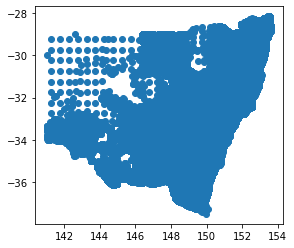

In [7]:
#Read the shapefile
abs_pathname = os.path.abspath("RFSNSW_BFPL.shp")
rfs_shapefile = gpd.read_file(abs_pathname)

#Check for null values in the file
rfs_shapefile = checkNull(rfs_shapefile)

#Show a plot of the data
rfs_shapefile.plot()

#Create table in pgAdmin
RFSNSW_BFPL = '''CREATE TABLE rfsnsw_bfpl (
                     "CATEGORY" NUMERIC, 
                     "SHAPE_LENG" NUMERIC, 
                     "SHAPE_AREA" VARCHAR(50), 
                     location GEOMETRY(POINT,4326))''' 

conn.execute("DROP TABLE IF EXISTS rfsnsw_bfpl")
conn.execute(RFSNSW_BFPL)

rfs_tablename = "rfsnsw_bfpl"

#Write data to pgAdmin table
rfs_shapefile.to_postgis(rfs_tablename, conn, if_exists='replace')

#Check that it has worked through a query
res = pd.read_sql_query('SELECT * FROM rfsnsw_bfpl', conn)
res

# Cleaning and Uploading SA2_2016_AUST

Null value found. Coverted null values to ...

Null values have been removed. You're good to go!


,CATEGORY,SHAPE_LENG,SHAPE_AREA,geometry
0,1,0.000017,5.392400e-12,0101000020BB100000FFA38A3F9FA362403BFC9C857487...
1,1,0.000178,1.140005e-09,0101000020BB100000948508C5CF0863409479FD58E3AE...
2,1,0.000890,4.950178e-08,0101000020BB10000049F954DE8E04634017589493C2AE...
3,1,0.000442,8.094091e-09,0101000020BB1000002BDB723DD308634089DD2B77BEAE...
4,1,0.000890,4.950155e-08,0101000020BB100000D649D9C9E0FF624097E74D1A6AAE...
...,...,...,...,...
516628,2,0.000942,3.484545e-08,0101000020BB100000392D3588FF2F63400752AF59047A...
516629,2,0.000457,8.385178e-09,0101000020BB1000006987ADCBFF2F634047713066EEA0...
516630,2,0.001833,1.341083e-07,0101000020BB1000002D750FCA00306340E932EDA84C84...
516631,2,0.012603,3.187411e-06,0101000020BB1000000C032703652C63402EA7684DC27F...


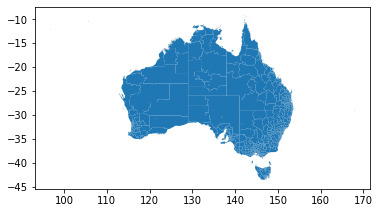

In [8]:
#Read the shapefile
abs_pathname = os.path.abspath("SA2_2016_AUST.shp")
sa_2_shapefile = gpd.read_file(abs_pathname)

#Run the function to check for null values
sa_2_shapefile = checkNull(sa_2_shapefile)

#Show a plot of the data 
sa_2_shapefile.plot()

#Create table in pgAdmin
SA2_2016 = '''CREATE TABLE sa2_2016 (
                     "SA2_MAIN16" NUMERIC, 
                     "SA2_5DIG16" NUMERIC, 
                     "SA2_NAME16" VARCHAR(50), 
                     "SA3_CODE16" NUMERIC, 
                     "SA3_NAME16" VARCHAR(50), 
                     "SA4_CODE16" NUMERIC,
                     "SA4_NAME16" VARCHAR(50), 
                     "GCC_CODE16" VARCHAR(50), 
                     "GCC_NAME16" VARCHAR(50),
                     "STE_CODE16" NUMERIC, 
                     "STE_NAME16" VARCHAR(50), 
                     "AREASQKM16" NUMERIC,
                     location GEOMETRY(MULTIPOLYGON,4326))''' 

conn.execute("DROP TABLE IF EXISTS sa2_2016")
conn.execute(SA2_2016)

sa2_tablename = "rfsnsw_bfpl"

#Write data to pgAdmin table
rfs_shapefile.to_postgis(rfs_tablename, conn, if_exists='replace')

#Check that it has worked through a query
res = pd.read_sql_query('SELECT * FROM rfsnsw_bfpl', conn)
res

# Cleaning and Uploading Additional Data Set

No Null Coordinates in this file. You're good to go!
Successfully created table for fire_stations


,geometry,fid,stationid,stationnam,stationtyp,brigadeid,lastupdate,dateverifi
0,0101000000F7E7014E27B36240F30B28933A4E40C0,1,0,Mudgee - HQ,1,15719,None,None
1,010100000027745E10F5BD6240406FD8A5A61540C0,2,0,Munmurra,1,15701,None,None
2,010100000041BC60AF2DBF6240357EB3B0086740C0,3,0,Rylstone,1,15724,None,None
3,010100000077AEB5EC3845624007BD9431891641C0,6,0,Myall Park,1,5505,None,None
4,0101000000A02D1B40914C62406FDD3C2E794141C0,7,0,Five Bough / Stony Point,1,7603,None,None
...,...,...,...,...,...,...,...,...
1851,0101000000598C45771C666240FFA1EDA9A58D3FC0,2297,0,Nyngan HQ 6,6,1418,20200611000000,None
1852,0101000000A00DED0E29826240E96FE4A4F7713FC0,2298,0,Pigeonbah 7,12,12815,20200611000000,None
1853,01010000004D2E1CB2EC9562403A9C471059E63EC0,2299,0,Pine Grove 1,6,3316,20200611000000,None
1854,0101000000AA8D1491619562402477FFC0E3F73EC0,2300,0,Pine Grove 7,12,3316,20200611000000,None


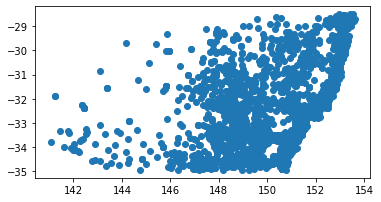

In [9]:
#Reading the json file
import json
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame

with open('RFSStation_EPSG4326.json') as f:
  fire_stations = json.load(f)
f.close()


i = 0
data_length = len(fire_stations['RFSStation']['features'])
null_found = False

while i < data_length:
    if len(fire_stations['RFSStation']['features'][i]['geometry']['coordinates']) < 2:
        print("Null coordinates found")
        null_found = True
        
    i += 1

if not null_found:
    print("No Null Coordinates in this file. You're good to go!")
    
fireStation_df = gpd.GeoDataFrame.from_features(fire_stations['RFSStation'])
fireStation_df.plot()

#Creating table for firestations
conn.execute("DROP TABLE IF EXISTS rfsfirestations")

RFS_FireStations = """CREATE TABLE IF NOT EXISTS rfsfirestations (
                        geometry GEOMETRY(Point) PRIMARY KEY,
                        fid INTEGER, 
                        stationid INTEGER,
                        stationnam VARCHAR(20),
                        stationtyp INTEGER,
                        brigadeid INTEGER
                   )"""

try:
     conn.execute(RFS_FireStations)
     print("Successfully created table for fire_stations")

except Exception as e:
     print("Table not created.\n")
     print(e)

#Write data to pgAdmin table
fireStation_df.to_postgis('rfsfirestations', conn, if_exists='replace')

#Query to check that the previous line has worked
res = pd.read_sql_query('SELECT * FROM rfsfirestations', conn)
res


# Joining Datasets

The process to joining all the tables involves:

Match SA2_MAIN16 (SA2_2016_AUST.shp) with area_id (neighbourhoods.csv) to narrow down the neighbourhoods we're interested in.

Spatial join the dataframe from (1) with RFSNSW_BFPL.shp to examine which area in the neighbourhood is prone to fire.

Spatial join dataframe from (1) with RFSStation_EPSG4326.json, to find out how many fire stations exist in each area of interest.

Join dataframe from (2) with (4), combining neighbourhoods that are prone to bush fire & the number of fire stations in each of the areas.

Join the dataframe from (4) with all the .csv files and all other columns from the .shp files.

Since, executing sql queries takes a very long time to load. Our team decided to execute our joins using pandas. Everything is done locally as the process is faster that way, then when we're done, we'll push all our results to pgAdmin

Process 1: Match SA2_MAIN16 (SA2_2016_AUST.shp) with area_id (neighbourhoods.csv) to narrow down the neighbourhoods we're interested in.

Area we're interested in:


,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,SA3_CODE16,SA3_NAME16,SA4_CODE16,SA4_NAME16,GCC_CODE16,GCC_NAME16,STE_CODE16,STE_NAME16,AREASQKM16,geometry,area_name,land_area,population,number_of_dwellings,number_of_businesses,median_annual_household_income,avg_monthly_rent
0,101051540,11540,Goulburn Region,10105,Goulburn - Mulwaree,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,9035.1221,"POLYGON ((149.09631 -34.41894, 149.09632 -34.4...",Goulburn Region,9035.1221,12670,6817,1528.0,62712.0,800.0
1,102011028,11028,Avoca Beach - Copacabana,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,6.4376,"POLYGON ((151.41373 -33.46559, 151.41361 -33.4...",Avoca Beach - Copacabana,643.8000,7590,2325,738.0,46996.0,1906.0


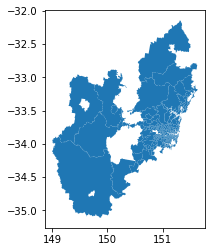

In [10]:
print("Process 1: Match SA2_MAIN16 (SA2_2016_AUST.shp) with area_id (neighbourhoods.csv) to narrow down the neighbourhoods we're interested in.")
# Renaming area_id to SA2_MAIN16 for matching column name
neighbourhoods_clean = neighbourhoods_clean.rename(columns={'area_id':'SA2_MAIN16'})
sa_2_shapefile['SA2_MAIN16'] = sa_2_shapefile['SA2_MAIN16'].astype(int)
join_neighbour_sa = sa_2_shapefile.merge(neighbourhoods_clean, on="SA2_MAIN16")
print("\nArea we're interested in:")
join_neighbour_sa.plot()

join_neighbour_sa.head(2)


Visualising the concentration of fire stations with the area of interest.


<ipython-input-11-c16eb29caf88>:5: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4283
Right CRS: None

  area_with_stations = gpd.sjoin(join_neighbour_sa, fireStation_df, op='contains')


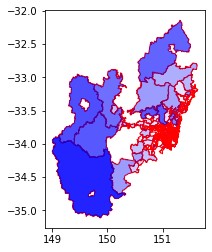

In [11]:
print("\nVisualising the concentration of fire stations with the area of interest.")

base = join_neighbour_sa.plot(color='white', edgecolor='red')

area_with_stations = gpd.sjoin(join_neighbour_sa, fireStation_df, op='contains')
area_with_stations.plot(ax=base, marker='o', color='blue', alpha=.05, markersize=1);

In [12]:
print ("Process 2: Spatial join the dataframe from (1) with RFSNSW_BFPL.shp to examine which area in the neighbourhood is prone to fire.")

neighbourhood_fire_prone = gpd.sjoin(join_neighbour_sa, rfs_shapefile, op='contains')
neighbourhood_fire_prone= neighbourhood_fire_prone.drop(columns=['index_right'])
neighbourhood_fire_prone = neighbourhood_fire_prone.set_index('SA2_MAIN16')

print("Table summarising areas that are prone to bush fires")
neighbourhood_fire_prone.head(2)

Process 2: Spatial join the dataframe from (1) with RFSNSW_BFPL.shp to examine which area in the neighbourhood is prone to fire.
Table summarising areas that are prone to bush fires


,SA2_5DIG16,SA2_NAME16,SA3_CODE16,SA3_NAME16,SA4_CODE16,SA4_NAME16,GCC_CODE16,GCC_NAME16,STE_CODE16,STE_NAME16,...,area_name,land_area,population,number_of_dwellings,number_of_businesses,median_annual_household_income,avg_monthly_rent,CATEGORY,SHAPE_LENG,SHAPE_AREA
SA2_MAIN16,,,,,,,,,,,,,,,,,,,,,
101051540,11540,Goulburn Region,10105,Goulburn - Mulwaree,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,...,Goulburn Region,9035.1221,12670,6817,1528.0,62712.0,800.0,1,0.00089,4.950178e-08
101051540,11540,Goulburn Region,10105,Goulburn - Mulwaree,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,...,Goulburn Region,9035.1221,12670,6817,1528.0,62712.0,800.0,1,0.00089,4.949777e-08


In [13]:
join_neighbour_sa

,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,SA3_CODE16,SA3_NAME16,SA4_CODE16,SA4_NAME16,GCC_CODE16,GCC_NAME16,STE_CODE16,STE_NAME16,AREASQKM16,geometry,area_name,land_area,population,number_of_dwellings,number_of_businesses,median_annual_household_income,avg_monthly_rent
0,101051540,11540,Goulburn Region,10105,Goulburn - Mulwaree,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,9035.1221,"POLYGON ((149.09631 -34.41894, 149.09632 -34.4...",Goulburn Region,9035.1221,12670,6817,1528.0,62712.0,800.0
1,102011028,11028,Avoca Beach - Copacabana,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,6.4376,"POLYGON ((151.41373 -33.46559, 151.41361 -33.4...",Avoca Beach - Copacabana,643.8000,7590,2325,738.0,46996.0,1906.0
2,102011029,11029,Box Head - MacMasters Beach,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,32.0860,"POLYGON ((151.35398 -33.49854, 151.35397 -33.4...",Box Head - MacMasters Beach,3208.6000,10986,3847,907.0,42621.0,1682.0
3,102011030,11030,Calga - Kulnura,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,767.9512,"MULTIPOLYGON (((151.20460 -33.53298, 151.20456...",Calga - Kulnura,76795.1000,4841,1575,1102.0,42105.0,1182.0
4,102011031,11031,Erina - Green Point,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,33.7934,"POLYGON ((151.36795 -33.43822, 151.36791 -33.4...",Erina - Green Point,3379.3000,14237,4450,1666.0,43481.0,1595.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,128021536,11536,Oyster Bay - Como - Jannali,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,8.9053,"POLYGON ((151.06905 -33.99818, 151.06907 -33.9...",Oyster Bay - Como - Jannali,890.5000,22084,5931,1591.0,55391.0,1947.0
305,128021538,11538,Sutherland - Kirrawee,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,7.7547,"POLYGON ((151.05049 -34.02006, 151.05098 -34.0...",Sutherland - Kirrawee,775.5000,21760,6924,2086.0,53378.0,1809.0
306,128021607,11607,Engadine,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,8.9538,"POLYGON ((150.99568 -34.05362, 150.99569 -34.0...",Engadine,895.4000,17424,5219,1121.0,52667.0,1955.0
307,128021608,11608,Loftus - Yarrawarrah,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,3.8436,"POLYGON ((151.03954 -34.04176, 151.03954 -34.0...",Loftus - Yarrawarrah,384.4000,7426,2177,417.0,51243.0,2163.0


In [14]:
fireStation_df

,geometry,fid,stationid,stationnam,stationtyp,brigadeid,lastupdate,dateverifi
0,POINT (149.59855 -32.61116),1,0,Mudgee - HQ,1,15719,None,None
1,POINT (149.93617 -32.16915),2,0,Munmurra,1,15701,None,None
2,POINT (149.97433 -32.80495),3,0,Rylstone,1,15724,None,None
3,POINT (146.16320 -34.17606),6,0,Myall Park,1,5505,None,None
4,POINT (146.39273 -34.51151),7,0,Five Bough / Stony Point,1,7603,None,None
...,...,...,...,...,...,...,...,...
1851,POINT (147.19097 -31.55331),2297,0,Nyngan HQ 6,6,1418,20200611000000,None
1852,POINT (148.06751 -31.44518),2298,0,Pigeonbah 7,12,12815,20200611000000,None
1853,POINT (148.68514 -30.89980),2299,0,Pine Grove 1,6,3316,20200611000000,None
1854,POINT (148.66816 -30.96832),2300,0,Pine Grove 7,12,3316,20200611000000,None


In [15]:
print("Process 3: Spatial join dataframe from (1) with RFSStation_EPSG4326.json, to find out how many fire stations exist in each area of interest.")

#Ensuring that all dataframe are of the same type, espg=4326
neighbourhood_fire_prone = neighbourhood_fire_prone.set_crs(epsg=4326,allow_override=True )
fireStation_df = fireStation_df.set_crs(epsg=4326,allow_override=True ) 
join_neighbour_sa = join_neighbour_sa.set_crs(epsg=4326,allow_override=True )

area_with_stations = gpd.sjoin(join_neighbour_sa, fireStation_df, op='contains')
area_with_stations = area_with_stations.set_index('SA2_MAIN16')
area_with_stations = area_with_stations['geometry'].to_frame()
area_with_stations = area_with_stations.groupby(['SA2_MAIN16']).count()
area_with_stations

Process 3: Spatial join dataframe from (1) with RFSStation_EPSG4326.json, to find out how many fire stations exist in each area of interest.


,geometry
SA2_MAIN16,
101051540,34
102011028,2
102011029,3
102011030,8
102011031,2
...,...
128021533,1
128021534,1
128021535,3


In [16]:
print("Process 3: Spatial join dataframe from (1) with RFSStation_EPSG4326.json, to find out how many fire stations exist in each area of interest.")

#Ensuring that all dataframe are of the same type, espg=4326
neighbourhood_fire_prone = neighbourhood_fire_prone.set_crs(epsg=4326,allow_override=True )
fireStation_df = fireStation_df.set_crs(epsg=4326,allow_override=True ) 
join_neighbour_sa = join_neighbour_sa.set_crs(epsg=4326,allow_override=True )

area_with_stations = gpd.sjoin(join_neighbour_sa, fireStation_df, op='contains')
area_with_stations = area_with_stations.set_index('SA2_MAIN16')
area_with_stations = area_with_stations['geometry'].to_frame()
area_with_stations = area_with_stations.groupby(['SA2_MAIN16']).count()

print("Summary of area code (SA2_MAIN16) and the amount of fire stations (geometry)")
area_with_stations

Process 3: Spatial join dataframe from (1) with RFSStation_EPSG4326.json, to find out how many fire stations exist in each area of interest.
Summary of area code (SA2_MAIN16) and the amount of fire stations (geometry)


,geometry
SA2_MAIN16,
101051540,34
102011028,2
102011029,3
102011030,8
102011031,2
...,...
128021533,1
128021534,1
128021535,3


In [17]:
print("Process 4: Join dataframe from (2) with (4), combining neighbourhoods that are prone to bush fire & the number of fire stations in each of the areas.")

neighbourhood_fire_prone = neighbourhood_fire_prone.groupby(neighbourhood_fire_prone.index).count()
mergeddf = neighbourhood_fire_prone.join(area_with_stations, how='left', lsuffix='neighbour', rsuffix='', sort=False)
mergeddf.fillna(0) #areas with 0 fire stations are valued at 0 instead of NA

summary = mergeddf['geometry'].to_frame()
summary = summary.rename(columns={"geometry": "stations_count"})
summary = summary.fillna(0)

print("Summary of areas that are prone to fire and the fire stations")
summary

Process 4: Join dataframe from (2) with (4), combining neighbourhoods that are prone to bush fire & the number of fire stations in each of the areas.
Summary of areas that are prone to fire and the fire stations


,stations_count
SA2_MAIN16,
101051540,34.0
102011028,2.0
102011029,3.0
102011030,8.0
102011031,2.0
...,...
128021536,0.0
128021538,0.0
128021607,1.0


In [18]:
print("Process 5: Join the dataframe from (4) with all the .csv files and all other columns from the .shp files.")

summary = summary.merge(neighbourhoods_clean, on='SA2_MAIN16')

businesStats_clean = businesStats_clean.rename(columns={"area_id": "SA2_MAIN16" })
summary = summary.merge(businesStats_clean, on='SA2_MAIN16')

statisticalAreas_clean = statisticalAreas_clean.rename(columns={"area_id": "SA2_MAIN16" })
summary = summary.merge(statisticalAreas_clean, on='SA2_MAIN16')

summary.head(2)

Process 5: Join the dataframe from (4) with all the .csv files and all other columns from the .shp files.


,SA2_MAIN16,stations_count,area_name_x,land_area,population,number_of_dwellings,number_of_businesses_x,median_annual_household_income,avg_monthly_rent,area_name_y,number_of_businesses_y,accommodation_and_food_services,retail_trade,agriculture_forestry_and_fishing,health_care_and_social_assistance,public_administration_and_safety,transport_postal_and_warehousing,area_name,parent_area_id
0,101051540,34.0,Goulburn Region,9035.1221,12670,6817,1528.0,62712.0,800.0,Goulburn Region,1891,38,52,1041,33,3,81,Goulburn Region,10105
1,102011028,2.0,Avoca Beach - Copacabana,643.8000,7590,2325,738.0,46996.0,1906.0,Avoca Beach - Copacabana,724,33,35,4,60,0,19,Avoca Beach - Copacabana,10201


In [19]:
combined_shape_file = gpd.sjoin(sa_2_shapefile, rfs_shapefile, how = 'inner', op = 'contains')
summary = combined_shape_file.merge(summary, on="SA2_MAIN16")
summary.head(2)

,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,SA3_CODE16,SA3_NAME16,SA4_CODE16,SA4_NAME16,GCC_CODE16,GCC_NAME16,STE_CODE16,...,area_name_y,number_of_businesses_y,accommodation_and_food_services,retail_trade,agriculture_forestry_and_fishing,health_care_and_social_assistance,public_administration_and_safety,transport_postal_and_warehousing,area_name,parent_area_id
0,101051540,11540,Goulburn Region,10105,Goulburn - Mulwaree,101,Capital Region,1RNSW,Rest of NSW,1,...,Goulburn Region,1891,38,52,1041,33,3,81,Goulburn Region,10105
1,101051540,11540,Goulburn Region,10105,Goulburn - Mulwaree,101,Capital Region,1RNSW,Rest of NSW,1,...,Goulburn Region,1891,38,52,1041,33,3,81,Goulburn Region,10105


# Performing Calculations

In [20]:
#Making a new data frame

working_frame = summary[['SA2_MAIN16', 
                               'area_name',
                               'stations_count', 
                               'land_area', 
                               'population', 
                               'number_of_dwellings',
                               'number_of_businesses_x', 
                               'median_annual_household_income',
                               'avg_monthly_rent',
                               'CATEGORY', 
                               'SHAPE_AREA',
                               'health_care_and_social_assistance']].copy()
working_frame.head(2)

,SA2_MAIN16,area_name,stations_count,land_area,population,number_of_dwellings,number_of_businesses_x,median_annual_household_income,avg_monthly_rent,CATEGORY,SHAPE_AREA,health_care_and_social_assistance
0,101051540,Goulburn Region,34.0,9035.1221,12670,6817,1528.0,62712.0,800.0,1,4.950178e-08,33
1,101051540,Goulburn Region,34.0,9035.1221,12670,6817,1528.0,62712.0,800.0,1,4.949777e-08,33


In [21]:
#Calculating bfpl 
working_frame = working_frame.drop_duplicates(subset='SA2_MAIN16')
bfpl = working_frame.groupby(['SA2_MAIN16']).sum()
bfpl.head(2)

#group bfpl based on their SA2_MAIN16, same area, and sum the fire category v

,stations_count,land_area,population,number_of_dwellings,number_of_businesses_x,median_annual_household_income,avg_monthly_rent,CATEGORY,SHAPE_AREA,health_care_and_social_assistance
SA2_MAIN16,,,,,,,,,,
101051540,34.0,9035.1221,12670,6817,1528.0,62712.0,800.0,1,4.950178e-08,33
102011028,2.0,643.8000,7590,2325,738.0,46996.0,1906.0,2,1.314487e-06,60


In [22]:
print("\nCalculating individual values...")
calculated_value = pd.DataFrame()
calculated_value['SA2_MAIN16'] = working_frame['SA2_MAIN16']
calculated_value['area_name'] = working_frame['area_name']
calculated_value['population_density'] = working_frame['population'] / working_frame['land_area']
calculated_value['dwelling_&_business_density'] = (working_frame['number_of_dwellings'] + working_frame['number_of_businesses_x'])/ working_frame['land_area']
calculated_value['bfpl_density'] =  (working_frame['SHAPE_AREA']*working_frame['CATEGORY']) / working_frame['land_area']
calculated_value['assistive_service_density'] = (working_frame['health_care_and_social_assistance'] +  working_frame['stations_count']) / working_frame['land_area']
calculated_value['median_income'] = working_frame['median_annual_household_income'] 
calculated_value['average_rent'] = working_frame['avg_monthly_rent']

calculated_value.head(2)


Calculating individual values...


,SA2_MAIN16,area_name,population_density,dwelling_&_business_density,bfpl_density,assistive_service_density,median_income,average_rent
0,101051540,Goulburn Region,1.402305,0.923618,5.478816e-12,0.007416,62712.0,800.0
17247,102011028,Avoca Beach - Copacabana,11.789376,4.757689,4.083525e-09,0.096303,46996.0,1906.0


In [23]:
#Calculating zScore for each column
zScore_df = pd.DataFrame()

zScore_df['area_name'] = calculated_value['area_name']

#Z Score Formula: (df.a - df.a.mean())/df.a.std(ddof=0)

zScore_df['population_density_zScore'] = (calculated_value.population_density - calculated_value.population_density.mean())/calculated_value.population_density.std(ddof=0)
zScore_df['dwelling_business_density_zScore'] = ( calculated_value['dwelling_&_business_density'] - calculated_value['dwelling_&_business_density'].mean())/ calculated_value['dwelling_&_business_density'].std(ddof=0)
zScore_df['bfpl_density_zScore'] =  (calculated_value.bfpl_density - calculated_value.bfpl_density.mean())/calculated_value.bfpl_density.std(ddof=0)
zScore_df['assistive_service_density_zScore'] = (calculated_value.assistive_service_density - calculated_value.assistive_service_density.mean())/calculated_value.assistive_service_density.std(ddof=0)
zScore_df['median_income'] = calculated_value['median_income']
zScore_df['average_rent'] = calculated_value['average_rent']

zScore_df = zScore_df.set_index(calculated_value['SA2_MAIN16'])
zScore_df.head(2)

,area_name,population_density_zScore,dwelling_business_density_zScore,bfpl_density_zScore,assistive_service_density_zScore,median_income,average_rent
SA2_MAIN16,,,,,,,
101051540,Goulburn Region,-1.061620,-0.846140,-0.300756,-0.678882,62712.0,800.0
102011028,Avoca Beach - Copacabana,-0.384077,-0.276991,-0.251126,-0.113400,46996.0,1906.0


In [24]:
print("\nCalculating the sigmoid value/ fire risk score")

data_length = len(zScore_df)

sigmoid_vals = []

x = zScore_df['population_density_zScore'] + zScore_df['dwelling_business_density_zScore'] + zScore_df['bfpl_density_zScore'] - zScore_df['assistive_service_density_zScore']
for val in x:
    sigmoid_vals.append(1/(1+math.exp(-val)))

zScore_df['sigmoid_val'] = sigmoid_vals
zScore_df.head(2)


Calculating the sigmoid value/ fire risk score


,area_name,population_density_zScore,dwelling_business_density_zScore,bfpl_density_zScore,assistive_service_density_zScore,median_income,average_rent,sigmoid_val
SA2_MAIN16,,,,,,,,
101051540,Goulburn Region,-1.061620,-0.846140,-0.300756,-0.678882,62712.0,800.0,0.178047
102011028,Avoca Beach - Copacabana,-0.384077,-0.276991,-0.251126,-0.113400,46996.0,1906.0,0.310283


# Graphing and Plotting


Plot fire risk score against median income


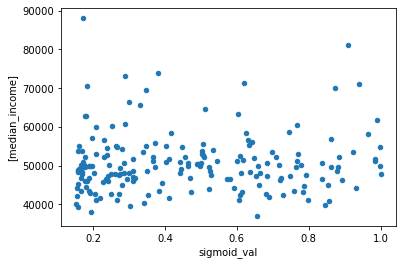

In [25]:
print("\nPlot fire risk score against median income")

zScore_df.plot(x="sigmoid_val",kind='scatter', y=["median_income"])
plt.show()


Plot fire risk score against average rent


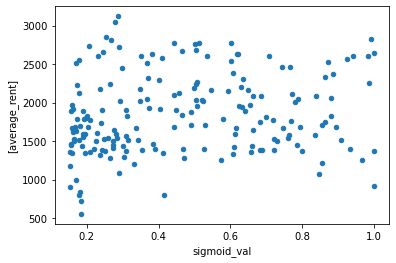

In [26]:
print("\nPlot fire risk score against average rent")

zScore_df.plot(x="sigmoid_val",kind='scatter', y=["average_rent"])
plt.show()

# Calculating Correlation

Finding the correlation coefficient between fire risk score and median income.

In [27]:
import numpy as np
median_score = zScore_df[zScore_df.columns[4]].to_numpy()
median_score

fire_score = zScore_df[zScore_df.columns[6]].to_numpy()
fire_score

r = np.corrcoef(fire_score, median_score)
r


array([[1.        , 0.44180708],
       [0.44180708, 1.        ]])

In [32]:
median_score = zScore_df[['sigmoid_val', 'median_income']].copy()
median_score


,sigmoid_val,median_income
SA2_MAIN16,,
101051540,0.178047,62712.0
102011028,0.310283,46996.0
102011029,0.204726,42621.0
102011030,0.154498,42105.0
102011031,0.189180,43481.0
...,...,...
128021536,0.633093,55391.0
128021538,0.698455,53378.0
128021607,0.507176,52667.0


In [33]:
median_score.corr(method = 'pearson')

,sigmoid_val,median_income
sigmoid_val,1.000000,0.058014
median_income,0.058014,1.000000


Finding the correlation coefficient between fire risk score and rent of a neighbourhood.

In [35]:
average_rent = zScore_df[["sigmoid_val", "average_rent"]]
average_rent

,sigmoid_val,average_rent
SA2_MAIN16,,
101051540,0.178047,800.0
102011028,0.310283,1906.0
102011029,0.204726,1682.0
102011030,0.154498,1182.0
102011031,0.189180,1595.0
...,...,...
128021536,0.633093,1947.0
128021538,0.698455,1809.0
128021607,0.507176,1955.0


In [37]:
average_rent.corr(method = 'pearson')

,sigmoid_val,average_rent
sigmoid_val,1.000000,0.167389
average_rent,0.167389,1.000000


In [41]:
import numpy as np
average_rent = zScore_df[zScore_df.columns[5]].to_numpy()

fire_score = zScore_df[zScore_df.columns[6]].to_numpy()

In [42]:
r = np.corrcoef(fire_score, average_rent)
r

array([[1.       , 0.3303929],
       [0.3303929, 1.       ]])

# Creating an Index

In this step, we will be uploading the completed table to PgAdmin and creating our index.

In [ ]:
zScore_df['index'] = zScore_df.index
zScore_df.head(2)


First, let's upload this table to PgAdmin.

In [ ]:
#Uploading StatisticalAreas.csv to pgAdmin

conn.execute("DROP TABLE IF EXISTS fireriskscores")

statistical_areas = """CREATE TABLE IF NOT EXISTS fireriskscores (
                         area_name VARCHAR(50),
                         population_density_zScore   FLOAT,
                         dwelling_business_density_zScore FLOAT,
                         bfpl_density_zScore FLOAT,
                         assistive_service_density_zScore   FLOAT,
                         median_income VARCHAR(20),
                         average_rent FLOAT,
                         sigmoid_val FLOAT,
                         index INTEGER

                   )"""
conn.execute(statistical_areas)
print("\nSuccessfully, created table fireriskscores...")

table_name = "fireriskscores"
zScore_df.to_sql(table_name, con=conn, if_exists='replace',index=False)
print ("\nUploaded fireriskscores dataset to pgAdmin")

res = pd.read_sql_query("SELECT * FROM fireriskscores",conn)
res

Now, let's make the index

In [ ]:
conn.execute("DROP INDEX IF EXISTS area_id")

creating_index = """CREATE INDEX area_id
                    ON fireriskscores(index);
                   """

conn.execute(creating_index)
print("\nSuccessfully, created index...")

res = pd.read_sql_query("SELECT * FROM fireriskscores",conn)
res